In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline

# An implementation of LightGBM for the Titanic problem

Using LightGBM's python API to predict Titanic survival.

First step is to load the provided train and test sets:

In [88]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print('Train shape:\t{} rows, {} cols\nTest shape:\t{} rows, {} cols'.format(train_df.shape[0], train_df.shape[1],
                                                                             test_df.shape[0], test_df.shape[1]))

Train shape:	891 rows, 12 cols
Test shape:	418 rows, 11 cols


In [89]:
mismatched_cols = [x for x in train_df.columns if x not in test_df.columns]
mismatched_cols

['Survived']

Stack the two datasets so that we can pre-process them as one. To do that, separate the label now.

In [90]:
y = train_df.pop('Survived')
train_df['dataset_label'] = 'train'
test_df['dataset_label'] = 'test'
df = train_df.append(test_df)

### Feature engineering

- Add any extra features that may be handy
- Encode and categoricals stores as strings
- Drop features that look difficult to get use out of

Want to make sure that everything I do to the training set happens to the test, so makes sense to run as a loop 

In [91]:
# Not sure passenger ID is useful as a feature, but need to save it from the test set for the submission
all_passenger_ids = df.pop('PassengerId')
test_passenger_ids = all_passenger_ids[df['dataset_label'] == 'test']

In [92]:
# Extract titles from the name feature if possible
df['Title'] = 'Other'
common_titles = ['Master', 'Mr', 'Miss', 'Mrs', 'Dr']
for title in common_titles:
    df.loc[df['Name'].str.contains(title), 'Title'] = title

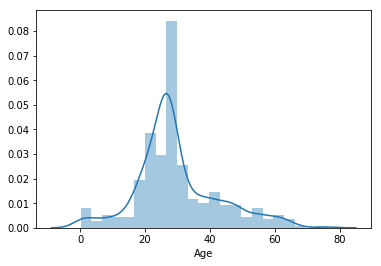

In [109]:
sns.distplot(df['Age'].fillna(df['Age'].median()))

In [93]:
# Features to drop - too many nulls or not useful
features_to_drop = ['Name', 'Ticket', 'Cabin']

# Record anyone travelling alone
df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)

# Categorical features. Take the object dtypes and add any others hiding as numbers
categorical_feats = [x for x in df.columns[df.dtypes == 'object'].tolist() \
                    if (x not in features_to_drop) and (x != 'dataset_label')]
categorical_feats += ['SibSp', 'Parch']

In [94]:
# Label encode the categoricals
for feat in categorical_feats:
    print('Encoding categorical feature {}'.format(feat))
    encoder = LabelEncoder()
    df[feat] = encoder.fit_transform(df[feat].fillna('Null'))

Encoding categorical feature Sex
Encoding categorical feature Embarked
Encoding categorical feature SibSp
Encoding categorical feature Parch


In [95]:
# Drop features that seem unusable. Save passenger ids if test
df.drop(features_to_drop, axis=1, inplace=True)

In [96]:
# Take a glance at the final dataset
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,dataset_label,Alone
0,3,1,22.0,1,0,7.2500,3,train,False
1,1,0,38.0,1,0,71.2833,0,train,False
2,3,0,26.0,0,0,7.9250,3,train,True
3,1,0,35.0,1,0,53.1000,3,train,False
4,3,1,35.0,0,0,8.0500,3,train,True


### Prep the training set for learning

In [97]:
# Re-separate the dataset
train_df = df[df['dataset_label'] == 'train'].copy()
test_df = df[df['dataset_label'] == 'test'].copy()
for df in [train_df, test_df]:
    df.drop('dataset_label', axis=1, inplace=True)

In [98]:
# Create an LGBM dataset for training
train_data = lgbm.Dataset(data=train_df, label=y, categorical_feature=categorical_feats, free_raw_data=False)

### Define hyperparameters for LGBM

Hyperparamters will be important - particularly given how small this data set is. I tuned them through cross-validation, trying to maximise accuracy as defined in the next code block

In [99]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 10,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 31,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15            # Every n boosting rounds, drop a tree
              }

Define classification accuracy as the evaluation metric for cross-validation. Using this instead of usually logloss or AUC simply becuase it is how Kaggle evaluates the result - may as well measure in the same way. Note I would usually not advocate accuracy as the sole classification measure!

In [100]:
def classification_accuracy(preds, train_data):
    labels = train_data.get_label()
    return 'accuracy', np.mean(labels == (preds > 0.5)), True

### Cross validate

Use CV to tweak the hyperparameters then train when happy with them

In [101]:
cv_results = lgbm.cv(train_set=train_data,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20,
                     feval=classification_accuracy)

/Users/jamesshepherd413/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	cv_agg's accuracy: 0.810392 + 0.0297093
[40]	cv_agg's accuracy: 0.820486 + 0.0277249
[60]	cv_agg's accuracy: 0.827215 + 0.0234681
[80]	cv_agg's accuracy: 0.826085 + 0.0234183
[100]	cv_agg's accuracy: 0.826079 + 0.0212286
[120]	cv_agg's accuracy: 0.821623 + 0.0207657
[140]	cv_agg's accuracy: 0.826117 + 0.0237414


Use CV results to get the best boosting round and train.

In [102]:
optimum_boost_rounds = np.argmax(cv_results['accuracy-mean'])
print('Best result was {:.4f} from boosting round {}'.format(cv_results['accuracy-mean'][optimum_boost_rounds],
                                                             optimum_boost_rounds))

Best result was 0.8317 from boosting round 50


In [103]:
clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)

/Users/jamesshepherd413/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


### Visualise training performance

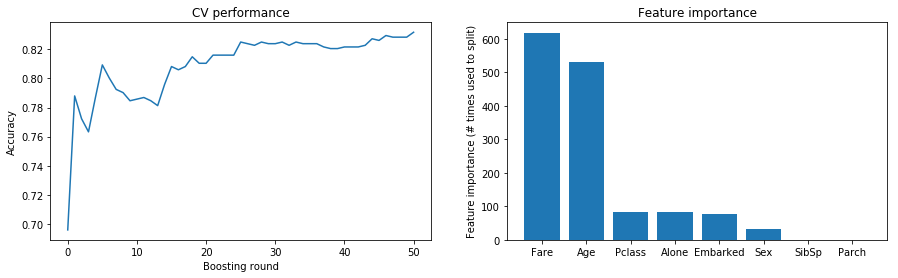

In [104]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(cv_results['accuracy-mean'], label='Accuracy score')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('CV performance')

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

### Make predictions on the test set

Using the parameters optimised above, retrain on all the data so we don't miss anything. Then make predictions on the
test set.

In [105]:
y_pred = np.round(clf.predict(test_df)).astype(int)

In [106]:
output_df = pd.DataFrame({'PassengerId': test_passenger_ids, 'Survived': y_pred})

# Output when local
output_df.to_csv('../output/predictions.csv', index=False)